# Example 9: $\chi \chi \to b \bar{b}$

In this notebook, we'll show you how to use the code to obtain the temperature and ionization histories for a dark matter particle with mass $m_\text{DM}$ that annihilates/decays into a pair of Standard Model particles with some (redshift-dependent) rate, characterized by either a thermally-averaged $s$-wave annihilation cross section $\langle \sigma v \rangle$ or a decay lifetime $\tau$. 

## Initialization

First, let's initialize some of the modules that are required. In order to perform the calculation, we need to point the code to a set of transfer functions that determine how high-energy particles in our code cool. 

The user must first download the data files located [*here*](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DUOUWA). When these files are required, the user will be prompted for the directory in which they are stored. To avoid this prompt, the directory can be entered into `data_path` defined in the [*config*](https://darkhistory.readthedocs.io/en/master/_autosummary/config.html) module. 

In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys

import main_dm_baryon_scattering as main

In [74]:
import config
from scipy.interpolate import interp1d

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

## Structure Formation

Dark matter annihilation rates are significantly enhanced after the formation of structures, owing to the fact that $\langle \rho^2 \rangle$ becomes greater than $\langle \rho_\text{DM} \rangle^2$, where $\rho_\text{DM}$ is the mass density of dark matter. To account for this increase in annihilation rate, boost factors, defined as

$$ 1 + \mathcal{B}(z) \equiv \frac{\langle \rho_\text{DM}^2 \rangle}{\langle \rho_\text{DM} \rangle^2} $$

have been computed under a wide variety of assumptions in the literature. The boost factor allows us to write the energy injection rate as

$$ \left( \frac{dE}{dV \, dt} \right)^\text{inj} = [1 + \mathcal{B}(z)] \left( \frac{dE}{dV \, dt} \right)^\text{inj}_\text{smooth} \,,$$

where the subscript 'smooth' indicates the smooth energy injection rate with the average mass density of dark matter assumed. 

In DarkHistory, we provide the 4 $s$-wave boost factors calculated in [[1]](#cite_2016), and shown in Fig. 2. We also include the $\text{erfc}$ model provided in [[2]](#cite_erfc), Eq. (2.7). The user can obtain these boost factors as *functions* that themselves return $1 + \mathcal{B}(z)$ as a function of redshift $1+z$, using [*struct_boost_func()*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.struct_boost_func.html) in [*physics*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics). See the documentation for details on how to use this function. Below, we use the "Einasto with substructure" model in [[1]](#cite_2016).

In [201]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
struct_boost_NFW = phys.struct_boost_func(model='NFW_no_subs')
struct_boost_pwave = phys.struct_boost_func(model='pwave_NFW_no_subs')

Let's plot this structure formation prescription to make sure that we have the right behavior. We'll make a plot of the effective density

$$ \rho_\text{eff} \equiv \sqrt{1 + \mathcal{B}(z)} \langle \rho_\text{DM} \rangle =  \sqrt{1 + \mathcal{B}(z)} \rho_{\text{DM},0} (1+z)^3 $$

where $\rho_{\text{DM},0}$ is the dark matter density today, which is stored in [*physics.rho_DM()*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.rho_DM.html). 

This plot should be directly compared with [[1]](#cite_2016). 

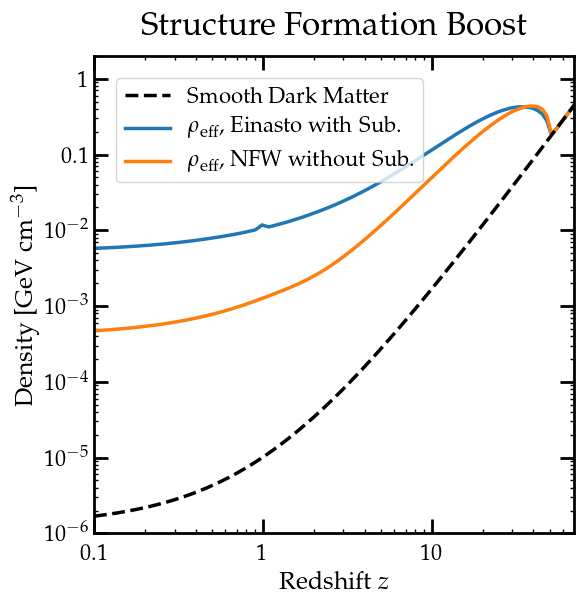

In [202]:
plt.figure()

plt.loglog()

z_vec = 10**np.arange(-1, 2, 0.005)
# Note that struct_boost accepts 1+z as the argument, which is the default
# way in which we pass redshift to functions in DarkHistory. 
rho_eff_vec = np.sqrt(struct_boost(1+z_vec)) * phys.rho_DM * (1+z_vec)**3 
rho_eff_vec_NFW = np.sqrt(struct_boost_NFW(1+z_vec)) * phys.rho_DM * (1+z_vec)**3 

# Convert to GeV/cm^3
rho_eff_vec /= 1e9
rho_eff_vec_NFW /= 1e9

rho_eff_plot,    = plt.plot(z_vec, rho_eff_vec, label=r'$\rho_\mathrm{eff}$, Einasto with Sub.')
rho_eff_plot_NFW,    = plt.plot(z_vec, rho_eff_vec_NFW, label=r'$\rho_\mathrm{eff}$, NFW without Sub.')
smooth_rho_plot, = plt.plot(z_vec, phys.rho_DM * (1+z_vec)**3 / 1e9, 'k--', label=r'Smooth Dark Matter')

plt.axis([0.1, 70, 1e-6, 2])
plt.xlabel('Redshift $z$')
plt.ylabel(r'Density [GeV cm$^{-3}$]')
plt.title('Structure Formation Boost')

plt.legend(handles=[smooth_rho_plot, rho_eff_plot, rho_eff_plot_NFW])

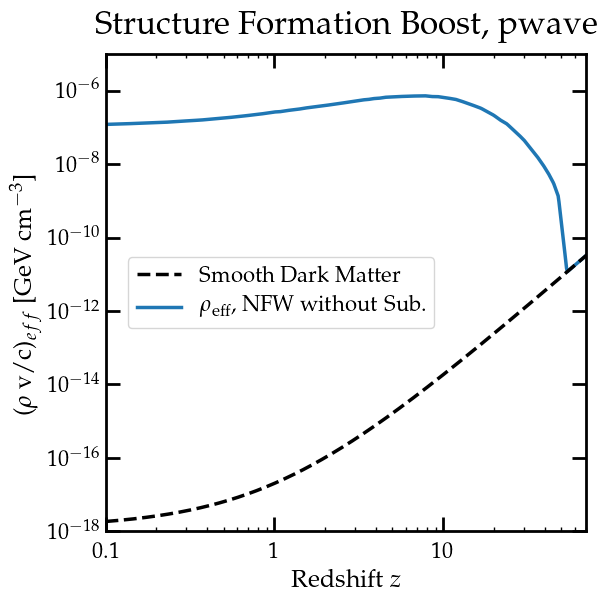

In [203]:
plt.figure()

plt.loglog()

z_vec = 10**np.arange(-1, 2, 0.005)

sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
rho_eff_vec_NFW = (sigma_1D_B/phys.c) * phys.rho_DM * (1+z_vec)**4 * np.sqrt(struct_boost_pwave(1+z_vec))

# Convert to GeV/cm^3
rho_eff_vec_NFW /= 1e9

# rho_eff_plot,    = plt.plot(z_vec, rho_eff_vec, label=r'$\rho_\mathrm{eff}$, Einasto with Sub.')
rho_eff_plot_NFW,    = plt.plot(z_vec, rho_eff_vec_NFW, label=r'$\rho_\mathrm{eff}$, NFW without Sub.')
smooth_rho_plot, = plt.plot(z_vec, 
                            (sigma_1D_B/phys.c) * phys.rho_DM * (1+z_vec)**4 / 1e9, 
                            'k--', label=r'Smooth Dark Matter')

plt.axis([0.1, 70, 1e-18, 1e-5])
plt.xlabel('Redshift $z$')
plt.ylabel(r'($\rho$ v/c)$_{eff}$ [GeV cm$^{-3}$]')
plt.title('Structure Formation Boost, pwave')

plt.legend(handles=[smooth_rho_plot, rho_eff_plot_NFW])

##  $b\bar{b}$ annihilation spectra

In the model we consider below, dark matter annihilates into b-quark/anti-quark pairs, $\chi\chi \to b \bar{b}$, which then resolve into spectra of stable particles.  As descibed in Section II of the paper, we need only consider the photon and electron/positron spectra, because the other stable particles (neutrinos, proton/anti-protons, heavier nuclei) are either ineffective at depositing their energy into the IGM or are produced in negligible amounts.

Below we plot the resulting photon and electron/positron spectra coming from $\chi\chi \to b \bar{b}$.

In [7]:
from darkhistory.spec.pppc import get_pppc_spec

In [8]:
eng = np.exp(np.array(
    [-9.171782342409985 + 0.07711606*i for i in np.arange(500)]
))
phot_spec = get_pppc_spec(50e9, eng, 'b', 'phot', decay=False)
elec_spec = get_pppc_spec(50e9, eng, 'b', 'elec', decay=False)

Text(0, 0.5, '$E^2 \\; \\frac{d\\mathbf{N}^e_\\mathrm{inj}}{dE}$')

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


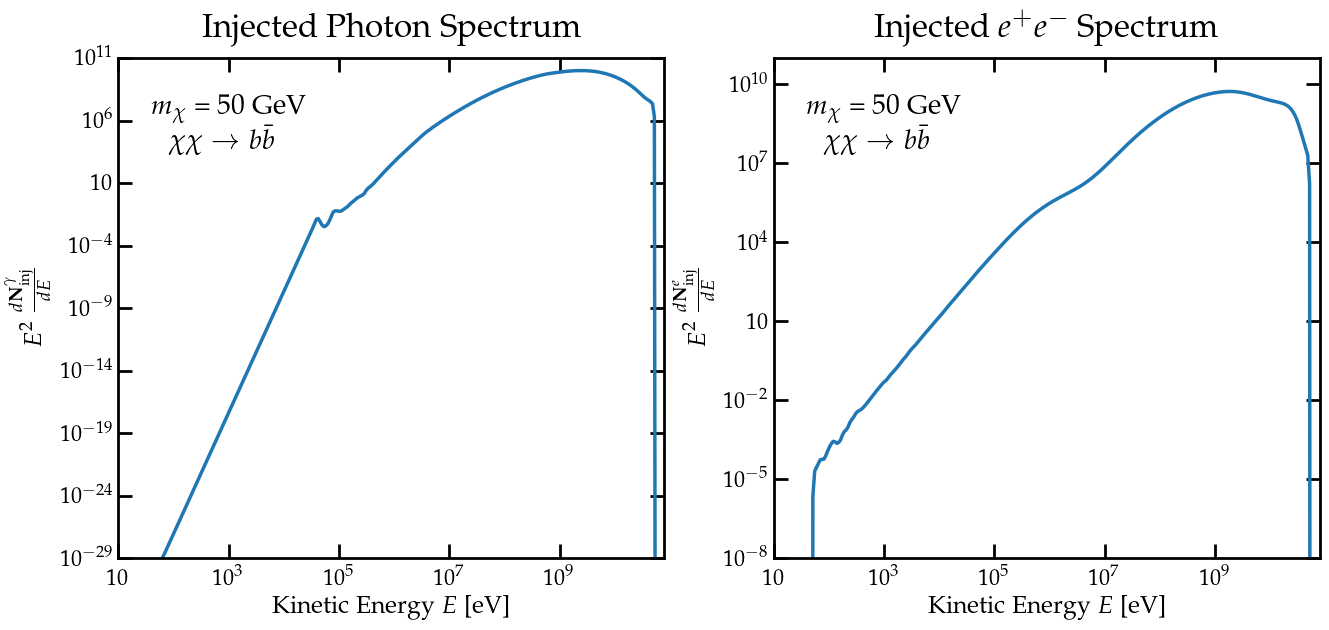

In [9]:
fig_bbbar = plt.figure(figsize=(15.5,6.5))

ax = plt.subplot(1,2,1)

ax.loglog()

plt.plot(phot_spec.eng, phot_spec.eng**2 * phot_spec.dNdE)

plt.axis([10, 80e9, 1e-29, 1e11])

plt.title(r'Injected Photon Spectrum')
plt.xlabel(r'Kinetic Energy $E$ [eV]')
plt.ylabel(r'$E^2 \; \frac{d\mathbf{N}^\gamma_\mathrm{inj}}{dE}$')

plt.text(0.06, 0.88, r'$m_\chi$ = 50 GeV', fontsize=20, transform=ax.transAxes)
plt.text(0.09, 0.82, r'$\chi\chi \to b \bar{b}$', fontsize=20, transform=ax.transAxes)



#################

ax = plt.subplot(1,2,2)

ax.loglog()

plt.plot(elec_spec.eng, elec_spec.eng**2 * elec_spec.dNdE)

plt.axis([10, 80e9, 1e-8, 1e11])

plt.text(0.06, 0.88, r'$m_\chi$ = 50 GeV', fontsize=20, transform=ax.transAxes)
plt.text(0.09, 0.82, r'$\chi\chi \to b \bar{b}$', fontsize=20, transform=ax.transAxes)


plt.title(r'Injected $e^+e^-$ Spectrum')
plt.xlabel(r'Kinetic Energy $E$ [eV]')
plt.ylabel(r'$E^2 \; \frac{d\mathbf{N}^e_\mathrm{inj}}{dE}$')

## $\chi \chi \to b \bar{b}$ Annihilation

We are now ready to obtain the ionization and thermal history for a dark matter model with $m_\chi = $ 50 GeV, and a thermally-averaged annihilation cross section of $\langle \sigma v \rangle = 2 \times 10^{-26} \mathrm{ cm}^{3} s^{-1}$. This model has been found to be consistent with the galactic center excess [[3]](#cite_excess) and the AMS-02 cosmic ray antiproton spectrum [[4]](#cite_AMS). 

The function we will use is [*main.evolve()*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). The function is called with the following arguments:

```python
def evolve(
    in_spec_elec=None, in_spec_phot=None,
    rate_func_N=None, rate_func_eng=None,
    DM_process=None, mDM=None, sigmav=None, lifetime=None, primary=None,
    struct_boost=None,
    start_rs=None, end_rs=4, helium_TLA=False,
    reion_switch=False, reion_rs=None,
    photoion_rate_func=None, photoheat_rate_func=None, xe_reion_func=None,
    init_cond=None, coarsen_factor=1, backreaction=True, 
    compute_fs_method='no_He', mxstep=1000, rtol=1e-4,
    use_tqdm=True
)
```

A full accounting of how to use all of the functions can be found throughout the examples given here and the documentation provided. Here we provide just a brief summary:

* `in_spec_elec`, `in_spec_phot`, `rate_func_N` and `rate_func_eng` are used to specify input electron and photon spectra per energy injection event, occurring at some event and energy injection rate. This allows the user to define energy injection processes of any type; 

* `DM_process`, `mDM`, `sigmav`, `lifetime`, `primary` and `struct_boost` are used for dark matter models with annihilation/decay with some mass, $\langle \sigma v \rangle$ or lifetime, forming some Standard Model primary particle and with some structure formation prescription;

* `start_rs` and `end_rs` to define the redshift boundaries of the problem (`start_rs` needs to be specified for DM processes, but not if `in_spec_elec` or `in_spec_phot` is in use, which should have its redshift initialized instead);

* `helium_TLA` determines whether to include helium or neglect it;

* `reion_switch`, `reion_rs`, `photoion_rate_func`, `photoheat_rate_func`, `xe_reion_func` are all passed to `darkhistory.tla.get_history` for purposes of modeling reionization; 

* `init_cond` allows the user to specify initial conditions in temperature and ionization levels that are not the baseline conditions at the starting redshift; 

* `coarsen_factor` determines how much coarsening to use; 

* `backreaction` controls whether $f_c(z)$ are evaluated using the baseline ionization levels, or if they are evaluated based on the calculated ionization levels, which would include the backreaction effect; 

* `compute_fs_method` controls how $f_c(z)$ is calculated; 

* `mxstep` and `rtol` are parameters that can be used to control the ODE solver, and

* `use_tqdm` controls whether to use the `tqdm` progress bar or not. 

When called for the first time, the data files that are downloaded as part of DarkHistory are loaded into memory for use by [*main.evolve()*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). The successful import of these files will generate the following output:

```
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
```

Once the files have been properly loaded, the calculation will begin.

Here is how we call the function to evaluate the ionization and temperature history for our dark matter model, *without* backreaction (we will run it with `coarsen_factor = 32` for speed). We do not include any reionization in this calculation, and also neglect helium here. 

In [66]:
%autoreload
pwave_noBR = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-24, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

In [76]:
%autoreload
pwave_24BR = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-24, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

In [74]:
%autoreload
pwave23 = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-23, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

In [77]:
%autoreload
pwave_23BR = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-23, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

In [75]:
%autoreload
pwave22 = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-22, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

In [78]:
%autoreload
pwave_22BR = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-22, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=4.004
)

The output is a dictionary with the following keys:

* `'rs'` -- the redshift abscissa of the outputs. 
* `'x'`  -- ($x_\text{HII}$, $x_\text{HeII}$) at each redshift point. 
* `'Tm'` -- $T_m$ at each redshift point. 
* `'highengphot'`, `'lowengphot'` and `'lowengelec'` -- the high-energy photon, low-energy photon and low-energy electron spectra at each step. 
* `'cmbloss'` -- the energy of CMB photons upscattered per unit time in each step. 
* `'f'`  -- A dictionary containing all the $f_c(z)$ values from both the low-energy spectra (`'low'`) and the high-energy electron deposition estimate (`'high'`). 

Next, let's run the same result *with* backreaction included.

Now let's make a plot comparing these two results. Pull out the relevant information first:

In [90]:
# Redshift abscissa. Identical for both cases. 
rs_vec = pwave_noBR['rs']

# Tm, stored in eV and converted to K. 
Tm24 = pwave_noBR['Tm']/phys.kB
Tm23 = pwave23['Tm']/phys.kB
Tm22 = pwave22['Tm']/phys.kB

Tm24BR = pwave_24BR['Tm']/phys.kB
Tm23BR = pwave_23BR['Tm']/phys.kB
Tm22BR = pwave_22BR['Tm']/phys.kB
# Tm_BR   = bbbar_BR['Tm']/phys.kB

# xHII. 
xHII24 = pwave_noBR['x'][:,0]
xHII23 = pwave23['x'][:,0]
xHII22 = pwave22['x'][:,0]

xHII24BR = pwave_noBR['x'][:,0]
xHII23BR = pwave_23BR['x'][:,0]
xHII22BR = pwave_22BR['x'][:,0]
# xHII_BR   = bbbar_BR['x'][:,0]

And now the plotting!

/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1390f6ad0> has a label of '_line3' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x139c7cb50> has a label of '_line4' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1390f6350> has a label of '_line5' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


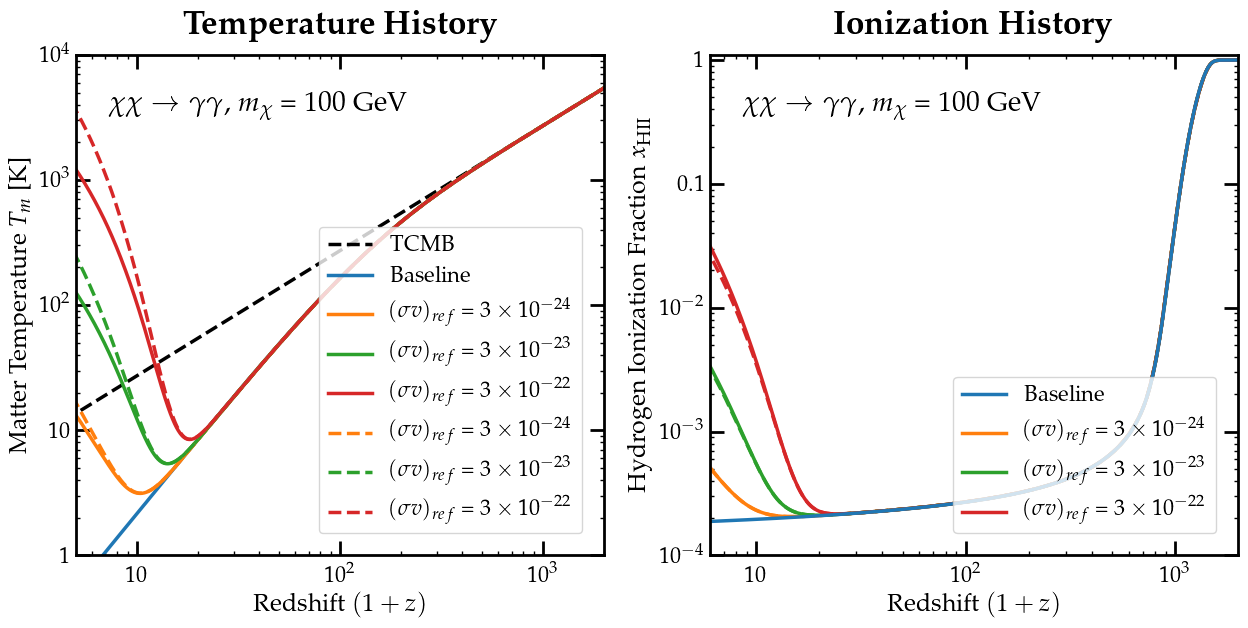

In [91]:
fig_bbbar = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

ax.loglog()

plot_Tm_std,    = plt.plot(rs_vec, phys.Tm_std(rs_vec)/phys.kB, 'C0', label='Baseline')
plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')
plot_Tm24,   = plt.plot(rs_vec, Tm24, 'C1', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
plot_Tm23,   = plt.plot(rs_vec, Tm23, 'C2', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
plot_Tm22,   = plt.plot(rs_vec, Tm22, 'C3', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

plot_Tm24BR,   = plt.plot(rs_vec, Tm24BR, 'C1--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
plot_Tm23BR,   = plt.plot(rs_vec, Tm23BR, 'C2--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
plot_Tm22BR,   = plt.plot(rs_vec, Tm22BR, 'C3--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

# plot_Tm_BR, = plt.plot(rs_vec, Tm_BR, label='With Backreaction')
# Plot the baseline result for comparison


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')

plt.axis([5, 2e3, 1, 1e4])

# Text
plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_TCMB, plot_Tm_std, plot_Tm24, plot_Tm23, plot_Tm22, 
                          plot_Tm24BR, plot_Tm23BR, plot_Tm22BR], loc=4)

#################

ax = plt.subplot(1,2,2)

ax.loglog()

plot_xHII24,   = plt.plot(rs_vec, xHII24, 'C1', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
plot_xHII23,   = plt.plot(rs_vec, xHII23, 'C2', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
plot_xHII22,   = plt.plot(rs_vec, xHII22, 'C3', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

plot_xHII24BR,   = plt.plot(rs_vec, xHII24BR, 'C1--')
plot_xHII23BR,   = plt.plot(rs_vec, xHII23BR, 'C2--')
plot_xHII22BR,   = plt.plot(rs_vec, xHII22BR, 'C3--')
# plot_xHII_BR, = plt.plot(rs_vec, xHII_BR, label='With Backreaction')
# Plot the baseline result for comparison
plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C0', label='Baseline')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([6, 2e3, 1e-4, 1.1])

# Text
plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_xHII_std, plot_xHII24, plot_xHII23, plot_xHII22, 
                         plot_xHII24BR, plot_xHII23BR, plot_xHII22BR], loc=4)

Although the temperature difference with and without backreaction is only about 50\% at $1+z = 4$, this is of course simply one example chosen to highlight how easy it is to get the temperature/ionization histories for any simple dark matter model. Models with decaying dark matter, for example, can lead to much larger differences. We will see an instance of this in a later example.

## Details

Importing `main` also imports a list of interpolation functions over various transfer functions. The first group of transfer functions involve propagation and deposition transfer functions that multiply a spectrum of propagating photons from a given redshift to give various quantities at the next redshift step. These include propagating photons (`highengphot_interp_tf`), low-energy photons (`lowengphot_interp_tf`), low-energy electrons (`lowengelec_interp_tf`), the energy of CMB photons upscattered per unit time (`CMB_engloss_interp`) and high-energy deposition (`highengdep_interp`). These interpolation functions are of type `TransferFuncInterps`, under the module `darkhistory.spec.transferfunclist`. See the documentation for more details on how to use these objects.

Together with these, there are also transfer function matrices that multiply a spectrum of electrons to give the spectrum of scattered photons per unit time in the Thomson (`ics_thomson_ref_tf`) and relativistic (`ics_rel_ref_tf`) regimes, as well as the energy loss spectrum per unit time (`ics_engloss_ref_tf`), i.e. number of photons which lose some amount of energy per unit time. These are used to work out how injected electrons cool in `main.evolve()`. 

# Compare to Fig. 1 of Hongwan/Tracy 21cm paper (also Histories_for_Comparison.ipynb)

Can we reproduce Fig. 1 of Hongwan/Tracy's 2016 paper?

In [8]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
inj_type = 'swave'
inj_param = 1e-29

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]

soln_std = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=inj_param*1e-60, primary='phot_delta',
    start_rs = rs_start,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [89]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
inj_type = 'swave'
inj_param = 1e-29

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
soln_cooling = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=1e-40, primary='phot_delta',
    start_rs = rs_start, reion_switch=False,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [ ]:
inj_param = 1e-29
mDM=1e8
soln_swave_BR = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=True,
    struct_boost=struct_boost_NFW,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [31]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]



mDM=3e6
lifetime = 8e25
soln_decay = main.evolve(
    DM_process='decay', mDM=mDM, lifetime=lifetime, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

soln_decayBR = main.evolve(
    DM_process='decay', mDM=mDM, lifetime=lifetime, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=True,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [ ]:
inj_param = 3e-24
soln_pwave = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [76]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

inj_param = 1e-26

soln_pwave_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=16,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [129]:
soln_std = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param*1e-40, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec*1e-40, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [138]:
soln_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param*1e-40, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [142]:
%autoreload
inj_param = 1e-26
soln_thermal_boost = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [153]:
%autoreload
inj_param = 1e-26
soln_pwave = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [166]:
%autoreload
inj_param = 1e-26
soln_pwave_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [257]:
%autoreload
inj_param = 1e-26
soln_total2 = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

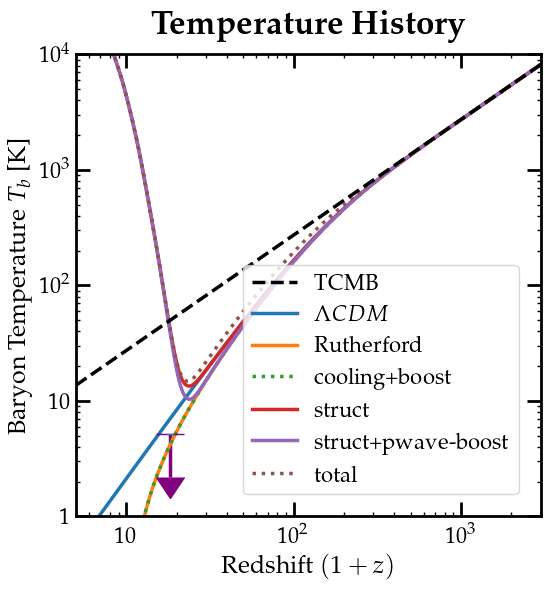

In [259]:
plt.figure(figsize=(6,6))
ax = plt.gca()

ax.loglog()

plot_Tm_std,    = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, 'C0', label='$\Lambda CDM$')
plot_TDM_std,    = plt.plot(soln_std['rs'], soln_std['T_DM']/phys.kB, 'C0', linestyle = '--')

plot_Tm_cooling,    = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, 'C1', label='Rutherford')
plot_TDM_cooling,    = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, 'C1', linestyle = '--')

plot_Tm_boost,    = plt.plot(soln_thermal_boost['rs'], soln_thermal_boost['Tm']/phys.kB, 'C2', label='cooling+boost', linestyle=':')
plot_TDM_boost,    = plt.plot(soln_thermal_boost['rs'], soln_thermal_boost['T_DM']/phys.kB, 'C2', linestyle = '--')

plot_Tm_pwave,    = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, 'C3', label='struct')

plot_Tm_pwave_cooling,    = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['Tm']/phys.kB, 'C4', label='struct+pwave-boost')
plot_TDM_pwave_cooling,    = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['T_DM']/phys.kB, 'C4', linestyle = '--')

plot_Tm_total,    = plt.plot(soln_total['rs'], soln_total2['Tm']/phys.kB, 'C5', label='total', linestyle=':')
plot_TDM_total,    = plt.plot(soln_total['rs'], soln_total2['T_DM']/phys.kB, 'C5', linestyle = '--')

# plot_Tm_decay,    = plt.plot(soln_decay['rs'], soln_decay['Tm']/phys.kB, 'C2', label='decay')
# plot_Tm_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['Tm']/phys.kB, 'C2--', label='decay w/ BR')

# TDM_boost2, = plt.plot(tmp2['rs'], tmp2['T_DM']/phys.kB, color='C1', linestyle='--', label=r'DM')
# Tm_boost2, = plt.plot(tmp2['rs'], tmp2['Tm']/phys.kB, color='C3', linestyle='--', label=r'Struct Boost')
plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)

plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Baryon Temperature $T_b$ [K]')

plt.axis([5, 3e3, 1, 1e4]) 


# leg = plt.legend(handles=[plot_TCMB, plot_Tm_std], loc=4)
leg = plt.legend(handles=
                 [plot_TCMB, plot_Tm_std, plot_Tm_cooling, plot_Tm_boost, 
                  plot_Tm_pwave, plot_Tm_pwave_cooling, plot_Tm_total], loc=4)

# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/standard_hist.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decay_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decayBR_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/21cm_constraint.pdf')

In [260]:
sigma_1D = 1e-11*(1e9/mDM)**0.5
fac = ((3*tmp2['T_DM']/mDM)/(sigma_1D * tmp2['rs'])**2 - 0*1.0)

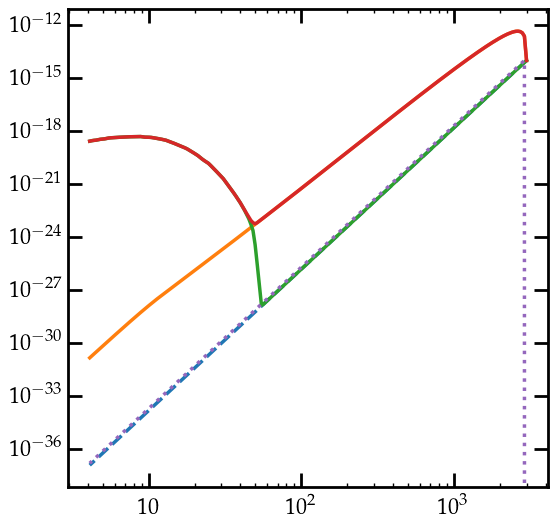

In [261]:
plt.figure()
ax = plt.gca()
ax.loglog()
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param),  linestyle='--')
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*fac)
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*struct_boost_pwave(soln_cooling['rs']))
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*(
    fac-1+struct_boost_pwave(soln_cooling['rs'])))
# plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*(
#     fac*struct_boost_pwave(soln_cooling['rs'])), color='C0')
plt.plot(soln_total['rs'], soln_total['V_pec'], linestyle=':')
# plt.plot(soln_total['rs'], soln_total['V_pec'], linestyle=':')
# plt.plot(soln_total['rs'], soln_pwave['V_pec'], color='C1')

In [197]:
soln_total['rs'][140]

34.000239464002014

In [419]:
sigma_1D_over_c = 1e-11*(1e9/1e8)**0.5
1e8 * sigma_1D_over_c**2 / 3 * tmp['rs']**2/tmp['T_DM']

array([1.        , 1.00010525, 1.00022041, 1.00036188, 1.00053194,
       1.00057699, 1.00058401, 1.00060581, 1.00082272, 1.00087975,
       1.00089818, 1.00091862, 1.00094136, 1.00096783, 1.00099864,
       1.00103453, 1.00107638, 1.00108435, 1.00109168, 1.00109923,
       1.00110163, 1.00125215, 1.00125366, 1.00125584, 1.00125714,
       1.00125796, 1.0012586 , 1.00125861, 1.00125871, 1.0012696 ,
       1.00126992, 1.00127063, 1.00127233, 1.00127515, 1.00128839])

In [454]:
tmp['T_DM']/(1e8 * sigma_1D_over_c**2 / 3 * tmp['rs']**2)

array([1.00000000e+00, 3.06489828e+01, 6.14901758e+01, 9.35725447e+01,
       1.26953214e+02, 1.61571373e+02, 1.97466018e+02, 2.34861110e+02,
       2.73574957e+02, 3.13726021e+02, 3.55454405e+02, 3.98904812e+02,
       4.44008339e+02, 4.90825032e+02, 5.39414088e+02, 5.89836538e+02,
       6.42155311e+02, 6.96484815e+02, 7.52847959e+02, 8.11315474e+02,
       8.71958589e+02, 9.34714854e+02, 9.99940025e+02, 1.06757405e+03,
       1.13769902e+03, 1.21039969e+03, 1.28576346e+03, 1.36388074e+03,
       1.44484436e+03, 1.52873997e+03, 1.61568760e+03, 1.70577895e+03,
       1.79911917e+03, 1.89581701e+03, 1.99597720e+03, 2.09972633e+03,
       2.20718909e+03, 2.31848949e+03, 2.43337661e+03, 2.55273204e+03,
       2.67632086e+03, 2.80429239e+03, 2.93678421e+03, 3.07396708e+03,
       3.21598766e+03, 3.36300728e+03, 3.51512298e+03, 3.67270247e+03,
       3.83582615e+03, 4.00468602e+03, 4.17948027e+03, 4.36041461e+03,
       4.54770287e+03, 4.74156720e+03, 4.94223869e+03, 5.14995766e+03,
      

In [17]:
np.exp(np.log(4000)-8000*.001)

1.3418505116100472

In [18]:
rs_vec = np.array([4000*np.exp(-.001*i) for i in np.arange(8000)])

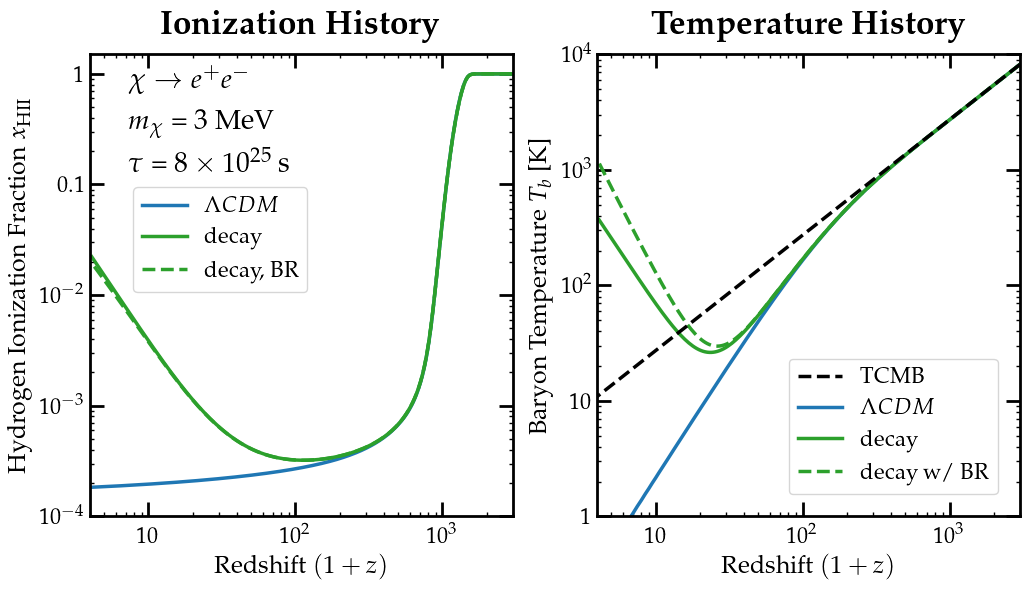

In [66]:
rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.loglog()

ax = plt.subplot(1,2,1)

ax.loglog()

plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C0', label='$\Lambda CDM$')
# plot_xHII_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['x'][:,0], 'C1', label='s-wave annihilation')
plot_xHII_decay,    = plt.plot(soln_decay['rs'], soln_decay['x'][:,0], 'C2', label='decay')
plot_xHII_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['x'][:,0], 'C2--', label='decay, BR')



plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([4, 3e3, 1e-4, 1.5])

# Text
interval = .08
plt.text(0.09, 0.93, r'$\chi \to e^+ e^-$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-interval-.02, r'$m_\chi$ = 3 MeV', fontsize=20, transform=ax.transAxes) 
# # plt.text(0.06, 0.88-interval*2-.02, r'$\langle \sigma v \rangle$ = $10^{-29}$ cm$^3$s$^{-1}$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-interval*2-.02, r'$\tau$ = $8 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

# Text
# plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_xHII_std, plot_xHII_decay, plot_xHII_decayBR], loc="upper left", bbox_to_anchor=(0.05,0.76))
# leg = plt.legend(handles=[plot_xHII_std], loc="upper left", bbox_to_anchor=(0.05,0.76))


#################

ax = plt.subplot(1,2,2)

ax.loglog()

plot_Tm_std,    = plt.plot(rs_vec, phys.Tm_std(rs_vec)/phys.kB, 'C0', label='$\Lambda CDM$')
# plot_Tm_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['Tm']/phys.kB, 'C1', label='s-wave annihilation')
# plot_Tm_BR,    = plt.plot(soln_swave_BR['rs'], soln_swave_BR['Tm']/phys.kB, 'C1', linestyle='--',label='s-wave, w/ backreaction')

plot_Tm_decay,    = plt.plot(soln_decay['rs'], soln_decay['Tm']/phys.kB, 'C2', label='decay')
plot_Tm_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['Tm']/phys.kB, 'C2--', label='decay w/ BR')


plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Baryon Temperature $T_b$ [K]')

plt.axis([4, 3e3, 1, 1e4]) 


# leg = plt.legend(handles=[plot_TCMB, plot_Tm_std], loc=4)
leg = plt.legend(handles=[plot_TCMB, plot_Tm_std, plot_Tm_decay, plot_Tm_decayBR], loc=4)

# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/standard_hist.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decay_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decayBR_example.pdf')

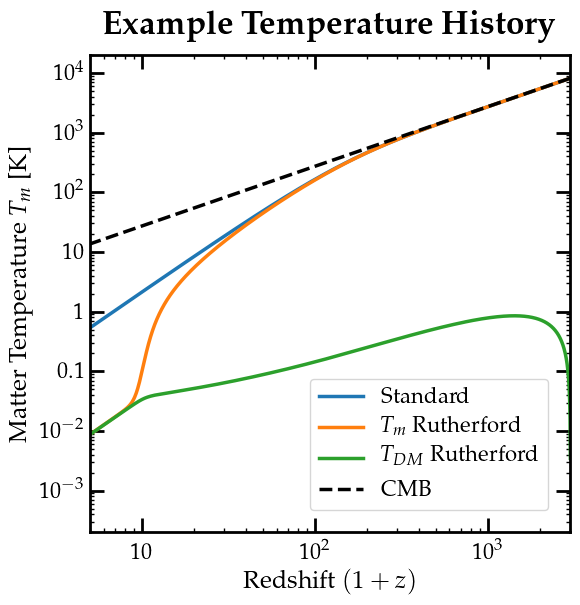

In [93]:
plt.figure()

ax = plt.gca()
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, label=r'Standard')
#Tm_swave, = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['Tm']/phys.kB, label=r'$s$-wave Annihilation')
#Tm_decay, = plt.plot(soln_decay2['rs'], soln_decay2['Tm']/phys.kB, label=r'Decay')
Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
# plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)
# Tm_decoupling, = plt.plot(soln_decoupling['rs'], soln_decoupling['Tm']/phys.kB, label=r'$(1+z)_\mathrm{td} = 500$')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
# Tm_pwave, = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, label=r'$p$-wave Annihilation')
# Tm_pwave_cooling, = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['Tm']/phys.kB, label=r'$p$-wave/Rutherford')
# Tm_boost, = plt.plot(tmp['rs'], tmp['Tm']/phys.kB, label=r'Everything')
# Tm_tmp, = plt.plot(tmp['rs'], tmp2['Tm']/phys.kB)
# Tm_tmp2, = plt.plot(tmp['rs'], tmp['T_DM']/phys.kB)



# Tm_pwave_cooling, = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, label=r'$p$-wave and cooling')

plt.legend(handles=[Tm_std, Tm_cooling, TDM_cooling, TCMB], loc=4)
# plt.legend(handles=[Tm_std, Tm_swave, Tm_pwave, Tm_decay, Tm_cooling, TDM_cooling, Tm_pwave_cooling, Tm_boost, TCMB], loc=4)
# plt.legend(handles=[Tm_std, Tm_pwave, Tm_cooling, TDM_cooling, Tm_pwave_cooling, Tm_boost, Tm_tmp, TCMB], loc=4)

# plt.tick_params(axis='both', which='major', length=10, width=2, labelsize=20, direction='in', top=True, right=True)
# plt.tick_params(axis='both', which='minor', length=3, width=1, labelsize=20, direction='in', top=True, right=True)

plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 3e3, 0.0002, 2e4])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')

# Millicharge

In [293]:
%autoreload


mDM = 1e7
fDM = 1
n = -4

eps = 5e-6
inj_type = 'swave'
species = 'elec'
inj_param = 1e28*0
start_rs=2000

soln_swave_eps = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.03,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

[4, 3000.0, 1e-05, 2]

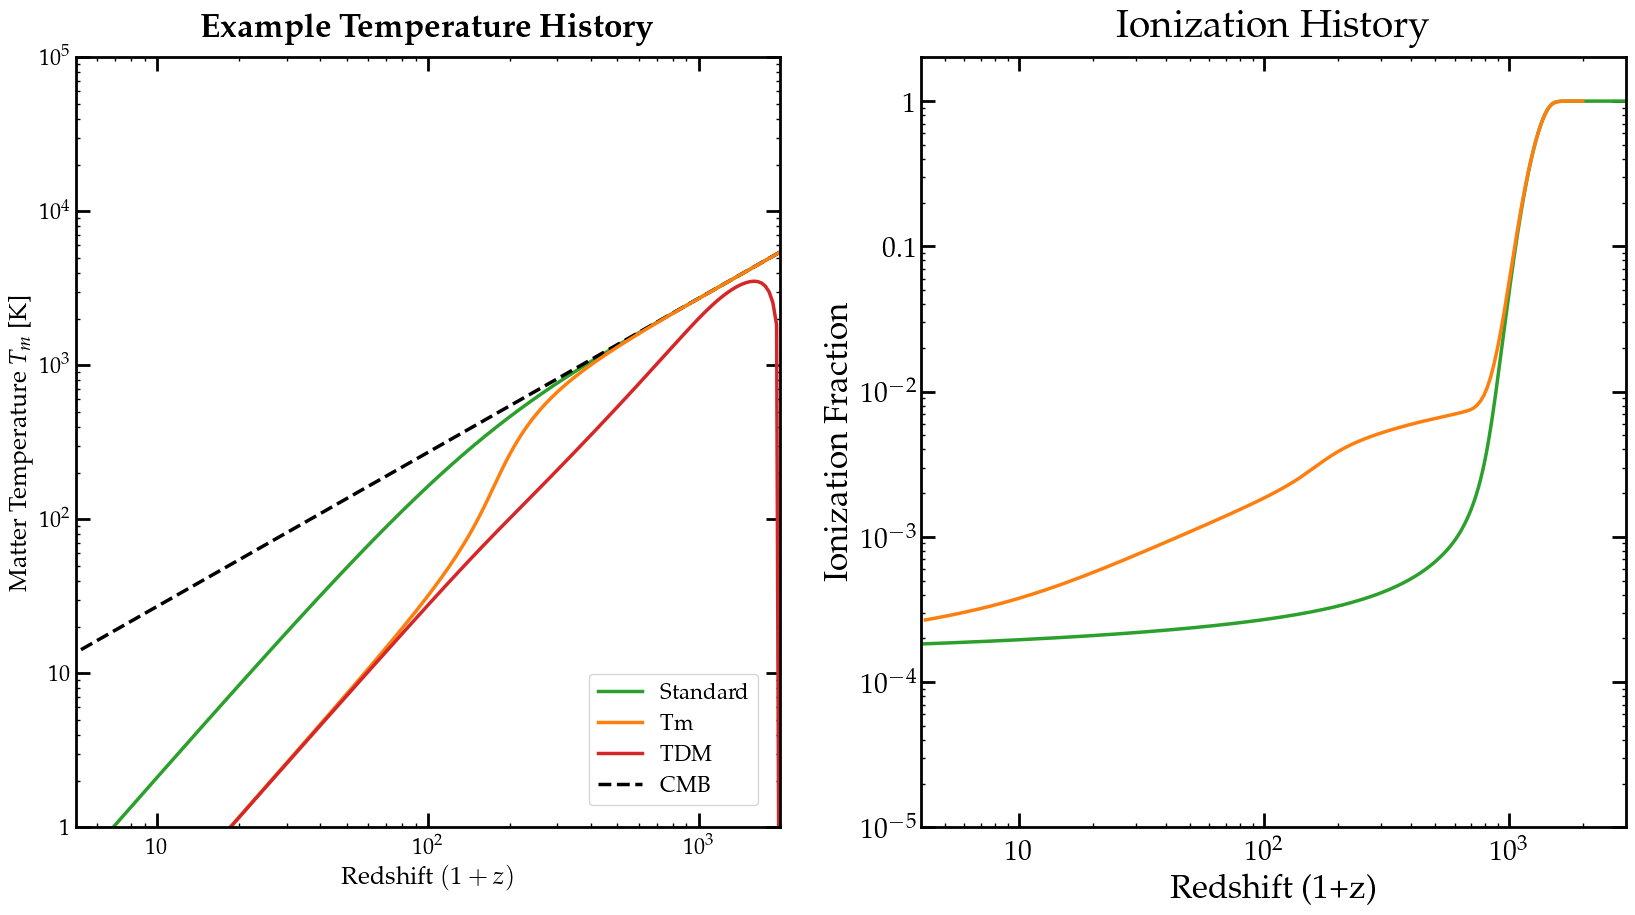

In [297]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, color='C2', label=r'Standard')
# Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
# TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_swave_eps_Tm, = plt.plot(soln_swave_eps['rs'], soln_swave_eps['Tm']/phys.kB, label='Tm', color='C1')
plt_swave_eps_TDM, = plt.plot(soln_swave_eps['rs'], soln_swave_eps['T_DM']/phys.kB, label='TDM', color='C3')

plt.legend(handles=[Tm_std, plt_swave_eps_Tm, plt_swave_eps_TDM, TCMB], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 2e3, 1, 1e5])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')



ax = plt.subplot(1,2,2)
plt.rc('text', usetex=True)
ax.loglog()

plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C2', label='$\Lambda CDM$')
# plot_xHII_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['x'][:,0], 'C1', label='s-wave annihilation')
plot_xHII_decay,    = plt.plot(soln_swave_eps['rs'], soln_swave_eps['x'][:,0], 'C1', label='decay')


plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([4, 3e3, 1e-4, 1.5])

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title(r'Ionization History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Ionization Fraction',fontsize=24)
plt.axis([4, 3e3, 1e-5, 2])

## pwave

In [313]:
%autoreload
mDM = 1e7
fDM = 4e-3
n = -4

eps = 3e-4
inj_type = 'pwave'
species = 'elec'
start_rs=3000
if species == 'elec':
    coarsen_factor=32
else:
    coarsen_factor=4

soln_pwave_eps = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=coarsen_factor, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=10,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

In [316]:
%autoreload
mDM = 1e7
fDM = 4e-3
n = -4

eps = 3e-4
inj_type = 'pwave'
species = 'elec'
start_rs=3000
if species == 'elec':
    coarsen_factor=32
else:
    coarsen_factor=4

soln_pwave_eps_noThermal = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=coarsen_factor, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

In [305]:
%autoreload
mDM = 1e7
fDM = 1e-2
n = -4

eps = 3e-4
inj_type = 'pwave'
species = 'elec'
start_rs=3000
if species == 'elec':
    coarsen_factor=32
else:
    coarsen_factor=4

soln_BR = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

[4, 3000.0, 1e-05, 2]

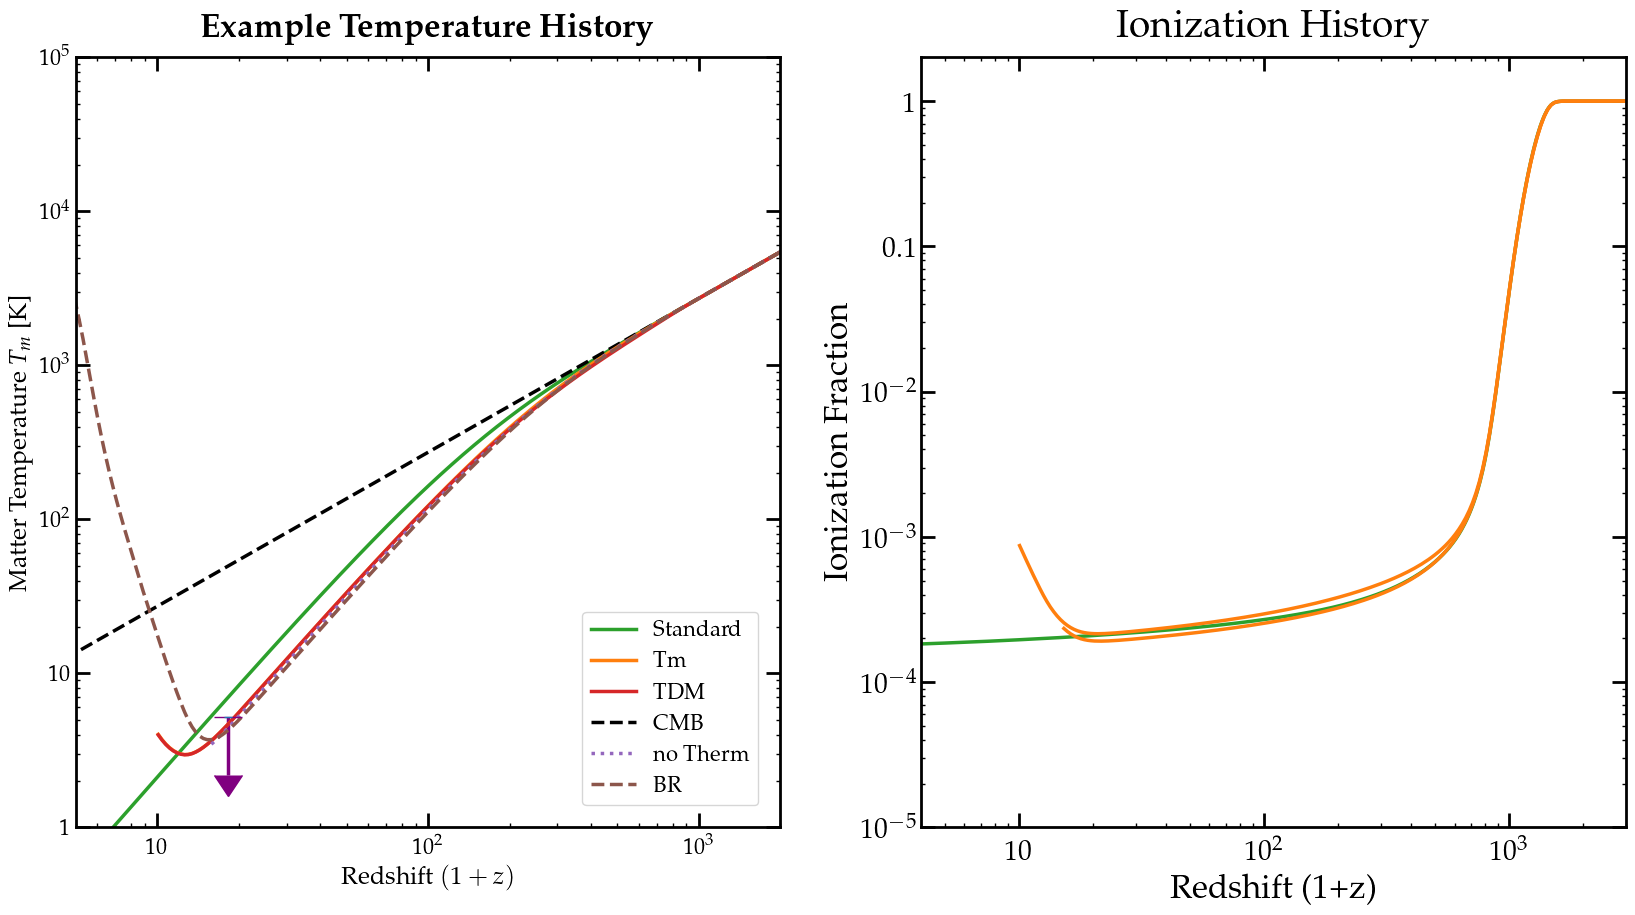

In [317]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, color='C2', label=r'Standard')
# Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
# TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_pwave_eps_Tm, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['Tm']/phys.kB, label='Tm', color='C1',linestyle=':')
plt_pwave_eps_TDM, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['T_DM']/phys.kB, label='TDM', color='C3', linestyle=':')
plt_pwave_eps_Tm_noThermal, = plt.plot(soln_pwave_eps_noThermal['rs'], soln_pwave_eps_noThermal['Tm']/phys.kB, label='no Therm', color='C4',linestyle=':')
plt_BR, = plt.plot(soln_BR['rs'], soln_BR['Tm']/phys.kB, label='BR', color='C5',linestyle='--')

plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)

plt.legend(handles=[Tm_std, plt_pwave_eps_Tm, plt_pwave_eps_TDM, TCMB,
                   plt_pwave_eps_Tm_noThermal,
                   plt_BR], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 2e3, 1, 1e5])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')



ax = plt.subplot(1,2,2)
plt.rc('text', usetex=True)
ax.loglog()

plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C2', label='$\Lambda CDM$')
# plot_xHII_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['x'][:,0], 'C1', label='s-wave annihilation')
plot_xHII_decay,    = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['x'][:,0], 'C1', label='decay')
plot_xHII_decay2,    = plt.plot(soln_pwave_eps_noThermal['rs'], soln_pwave_eps_noThermal['x'][:,0], 'C1', label='decay')



plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([4, 3e3, 1e-4, 1.5])

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title(r'Ionization History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Ionization Fraction',fontsize=24)
plt.axis([4, 3e3, 1e-5, 2])